In [20]:
# conda env: datacat (Python 3.8.20)
"""
Prepare FS-MOl like datasets for use with ClipGPCR.
example call:
python datacat4ml/Scripts/data_split/prep_fsmol_alike.py
"""
import sys
import os

from enum import Enum
from typing import List, Optional, Dict, Union
import logging
logger = logging.getLogger(__name__)
import json
import pandas as pd
from collections import defaultdict
import tqdm
from pathlib import Path
import missingno as msno


from datacat4ml.const import SPLIT_DATA_DIR, CURA_CAT_GPCR_DIR, CURA_CAT_OR_DIR

# DataFold

In [2]:
class DataFold(Enum):
    TRAIN = 0
    VALIDATION = 1
    TEST =2

# Process the data split

In [3]:
split_dir = SPLIT_DATA_DIR
cura_dir = CURA_CAT_GPCR_DIR
#----------
sys.path.insert(0, dir)
sys.path.insert(0, os.path.join(split_dir, 'fsmol_alike'))

# read MHDsFold.json file:

with open(os.path.join(split_dir, 'MHDsFold.json'), 'r') as f:
    MHDsFold = json.load(f)

train_files = MHDsFold['train']
valid_files = MHDsFold['valid']
test_files = MHDsFold['test']

# read the files in path cura_dir as a pandas dataframe
train_data = [os.path.join(CURA_CAT_GPCR_DIR, 'cls', f) for f in train_files]
train_df = pd.concat([pd.read_csv(f, index_col=0) for f in train_data], ignore_index=True)
valid_data = [os.path.join(CURA_CAT_GPCR_DIR, 'cls', f) for f in valid_files]
valid_df = pd.concat([pd.read_csv(f, index_col=0) for f in valid_data], ignore_index=True)
# here is CURA_CAT_OR_DIR 
test_data = [os.path.join(CURA_CAT_OR_DIR, 'cls', f) for f in test_files]
test_df = pd.concat([pd.read_csv(f, index_col=0) for f in test_data], ignore_index=True)

In [4]:
# add one column 'relationship_desc' based on the column 'relationship_type'
effect_dict = {
    'bind': 'binding affinity',
    'agon': 'agonism',
    'antag': 'antagonism'}

assay_dict = {
    'RBA': 'Receptor binding assay: radioligand binding assay',
    'G_GTP': 'G-protein dependent functional assays: GTPγS binding assay',
    'G_cAMP': 'G-protein dependent functional assays: cAMP accumulation assay',
    'G_Ca': 'G-protein dependent functional assays: IP3/IP1 and calcium accumulation assays',
    'B_arrest': 'Arrestin recruitment assay',
}


def map_columns(df):
    """
    Map the relationship_type to relationship_desc
    """
    df['effect_desc'] = df['effect'].map(effect_dict)
    df['assay_kw_desc'] = df['assay'].map(assay_dict)

    return df

def formate_type(df):
    """
    Format the type of the dataframe
    """
    df['aidx'] = df['aidx'].astype(str)

    return df

train_mapped_df = map_columns(train_df)
train_formated_df = formate_type(train_mapped_df)
valid_mapped_df = map_columns(valid_df)
valid_formated_df = formate_type(valid_mapped_df)
test_mapped_df = map_columns(test_df)
test_formated_df = formate_type(test_mapped_df)

print(f"train_formated_df: {train_formated_df.shape}")
print(f"valid_formated_df: {valid_formated_df.shape}")
print(f"test_formated_df: {test_formated_df.shape}")
print(f'The columns in the train_df are: {train_formated_df.columns}')

train_formated_df: (189667, 50)
valid_formated_df: (1462, 50)
test_formated_df: (20377, 50)
The columns in the train_df are: Index(['assay_id', 'assay_chembl_id', 'tid', 'target_chembl_id',
       'standard_type', 'standard_relation', 'standard_value',
       'standard_units', 'pchembl_value', 'assay_type', 'assay_type_desc',
       'assay_category', 'assay_organism', 'assay_tax_id', 'assay_strain',
       'assay_tissue', 'assay_cell_type', 'assay_subcellular_fraction',
       'bao_format', 'bao_label', 'variant_id', 'assay_test_type',
       'assay_desc', 'cell_id', 'tissue_id', 'curated_by', 'relationship_type',
       'relationship_type_desc', 'aidx', 'confidence_score',
       'confidence_score_desc', 'molregno', 'compound_chembl_id',
       'canonical_smiles', 'assay_info_hash', 'canonical_smiles_by_Std',
       'molecular_weight', 'num_atoms', 'pStandard_value', 'max_num_atoms',
       'max_molecular_weight', 'activity_string', 'activity', 'threshold',
       'target', 'effect', 

In [5]:
def preprocess_dataset_splits(split_dfs: dict, output_dir):
    """
    Preprocess the datasets (train/valid/test) into CLIP-compatible format.

    Args:
        split_dfs (dict): Dictionary with keys 'train', 'valid', 'test' and values as corresponding pandas DataFrames.
        output_dir (str or Path): Directory to write the processed .parquet files.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    tasks_dic = defaultdict(list)
    activity_triplet = []
    assay_info = []
    compound2index = {}
    activity2index = {}

    logger.info('Preprocessing datasets: train, valid, test')

    for split_name, df in split_dfs.items():
        logger.info(f"Processing split: {split_name}")
        for _, row in df.iterrows():
            # for compound2index, activity2index and activity triplet
            assay_id = row['assay_id']
            compound_smiles = row['canonical_smiles_by_Std']
            label = row['activity']                  # binary: 0 or 1
            label_numeric = row['pStandard_value']   # regression label

            assay_chembl_id = row['assay_chembl_id']
            assay_type = row['assay_type']
            assay_type_desc = row['assay_type_desc']
            assay_category = row['assay_category']
            assay_organism = row['assay_organism']
            assay_tax_id = row['assay_tax_id']
            assay_strain = row['assay_strain']
            assay_tissue = row['assay_tissue']
            assay_cell_type = row['assay_cell_type']
            assay_subcellular_fraction = row['assay_subcellular_fraction']
            bao_format = row['bao_format']
            bao_label = row['bao_label']
            variant_id = row['variant_id']
            assay_test_type = row['assay_test_type']
            assay_desc = row['assay_desc']

            cell_id = row['cell_id']
            tissue_id = row['tissue_id']
            relationship_type = row['relationship_type']
            relationship_type_desc = row['relationship_type_desc']
            aidx = row['aidx']
            confidence_score = row['confidence_score']
            confidence_score_desc = row['confidence_score_desc']
            tid = row['tid']

            target_chembl_id = row['target_chembl_id']
            effect = row['effect']
            effect_desc = row['effect_desc']
            assay = row['assay']
            assay_kw_desc = row['assay_kw_desc']
            std_type = row['std_type']

            standard_relation = row['standard_relation']
   
            # Compound index
            cid_index = compound2index.get(compound_smiles, len(compound2index))
            compound2index[compound_smiles] = cid_index

            # Assay index
            aid_index = activity2index.get(assay_id, len(activity2index))
            activity2index[assay_id] = aid_index

            # Save task name per split
            tasks_dic[split_name].append(assay_id)

            # Append activity triplet
            activity_triplet.append({
                'compound_idx': cid_index,
                'assay_idx': aid_index,
                'activity': int(label),
                'activity_numeric': label_numeric,
                'split': split_name,
            })

            # append assay info
            assay_info.append({
                'assay_idx': aid_index,  

                'assay_id': assay_id,
                'assay_chembl_id': assay_chembl_id,
                'assay_desc': assay_desc,

                'assay_type': assay_type,
                'assay_type_desc': assay_type_desc,
                'assay_category': assay_category,
                'assay_organism': assay_organism,
                'assay_tax_id': assay_tax_id,
                'assay_strain': assay_strain,
                'assay_tissue': assay_tissue,
                'assay_cell_type': assay_cell_type,
                'assay_subcellular_fraction': assay_subcellular_fraction,
                'bao_format': bao_format,
                'bao_label': bao_label,
                'variant_id': variant_id,
                'assay_test_type': assay_test_type,
                
                'cell_id': cell_id,
                'tissue_id': tissue_id,
                'relationship_type': relationship_type,
                'relationship_type_desc': relationship_type_desc,
                'aidx': aidx,
                'confidence_score': confidence_score,
                'confidence_score_desc': confidence_score_desc,
                
                'tid': tid,
                'target_chembl_id': target_chembl_id,
                'effect': effect,
                'effect_desc': effect_desc,
                'assay': assay,
                'assay_kw_desc': assay_kw_desc,
                'std_type': std_type,
                'standard_relation': standard_relation,
                'split': split_name,
            })


    # Save activity triplet
    activity_triplet_df = pd.DataFrame(activity_triplet)
    activity_triplet_df.to_parquet(output_dir / 'activity.parquet')

    # Save assay info
    assay_info_df = pd.DataFrame(assay_info)
    assay_info_df.to_parquet(output_dir / 'assay_info.parquet')

    # Save compound smiles
    compound_smiles_df =pd.DataFrame({
        'CID': list(compound2index.values()),
        'CanonicalSMILES': list(compound2index.keys())
    })
    compound_smiles_df.to_parquet(output_dir / 'compound_smiles.parquet')


    # save compound index
    compound_names_df = pd.DataFrame({
        'CID': list(compound2index.values()), 
    })
    compound_names_df.to_parquet(output_dir / 'compound_names.parquet')

    logger.info(f'Finished preprocessing. Files saved to: {output_dir}')

    return activity_triplet_df, assay_info_df, compound_smiles_df, compound_names_df

In [6]:
split_dfs = {
    'train': train_df,
    'valid': valid_df,
    'test': test_df
}

activity_triplet_df, assay_info_df, compound_smiles_df, compound_names_df = preprocess_dataset_splits(split_dfs, output_dir=os.path.join(split_dir, 'fsmol_alike', 'MHDsFold'))

# Visualize the `parquet` files

## `activity.parquet`

In [7]:
print(f"{activity_triplet_df['split'].value_counts()}\n")
print(f"The number of unique compounds in the dataset is: {activity_triplet_df['compound_idx'].nunique()} \n")
print(f"The number of unique assays in the dataset is: {activity_triplet_df['assay_idx'].nunique()} \n")
print(f"The active/inactive ratio is {sum(activity_triplet_df['activity']) / len(activity_triplet_df['activity'])} \n")
activity_triplet_df

split
train    189667
test      20377
valid      1462
Name: count, dtype: int64

The number of unique compounds in the dataset is: 118736 

The number of unique assays in the dataset is: 18292 

The active/inactive ratio is 0.8490066475655537 



,compound_idx,assay_idx,activity,activity_numeric,split
0,0,0,1,6.779892,train
1,1,1,1,5.742321,train
2,2,1,1,5.832683,train
3,3,1,0,5.000000,train
4,4,1,0,5.000000,train
...,...,...,...,...,...
211501,118424,18288,1,8.113509,test
211502,118425,18288,1,7.050610,test
211503,118734,18289,0,4.522879,test
211504,118428,18290,0,5.000000,test


## `compound_smiles.parquet` & `compound_names.parquet`

In [8]:
compound_smiles_df

,CID,CanonicalSMILES
0,0,CNC1CCN(c2ccc(NC(=O)c3ccc(-c4ccccc4)cc3)cc2)C1
1,1,O=C(CNCc1ccc(Oc2ccccc2)cc1)Nc1ccc2ncn(CCN3CCCC...
2,2,O=C(Cc1ccc(OCc2ccccc2)cc1)Nc1ccc2ccn(CCN3CCCC3...
3,3,O=C(Cc1ccc(OCc2ccccc2)cc1)Nc1ccc2ncn(CCN3CCCC3...
4,4,O=C(Cc1ccc(OCc2ccccc2)cc1)Nc1ccc2c(c1)ncn2CCN1...
...,...,...
118731,118731,CC(C)CN(C(=O)c1cccc(Cl)c1Cl)[C@H]1CCNC1
118732,118732,CCCCCC=Cc1c(O)cc(C=CC(C)C)c2c1CC(O)O2
118733,118733,Nc1ccnc(-c2cc(-c3ccon3)n(Cc3ccccc3F)n2)n1
118734,118734,CC(C)C[C@@H](N)C(=O)Nc1ccc(-c2cnco2)c(OC(F)F)c1


## `assay_info.parquet` 

In [ ]:
# General info
print(f'The number of unique assays in the dataset is {assay_info_df["assay_idx"].nunique()} \n')
print(f'The number of unique target is {assay_info_df["target_chembl_id"].nunique()} \n')
print(f"{assay_info_df['split'].value_counts()}\n")
print(f"{assay_info_df['confidence_score'].value_counts()}\n")
print(f"{assay_info_df['effect'].value_counts()}\n")
print(f"{assay_info_df['assay'].value_counts()}\n")
print(f"{assay_info_df['std_type'].value_counts()}\n")
print(f'The columns in the assay_info_df are: {assay_info_df.columns} \n')
assay_info_df

The number of unique assays in the dataset is 18292 

The number of unique target is 203 

split
train    189667
test      20377
valid      1462
Name: count, dtype: int64

confidence_score
9    160898
8     50608
Name: count, dtype: int64

effect
bind     153322
agon      37540
antag     20644
Name: count, dtype: int64

assay
RBA         153322
G_Ca         23599
G_cAMP       17602
G_GTP        12431
B_arrest      4552
Name: count, dtype: int64

std_type
Ki      119590
IC50     56761
EC50     35155
Name: count, dtype: int64

The columns in the assay_info_df are: Index(['assay_idx', 'assay_id', 'assay_chembl_id', 'assay_desc', 'assay_type',
       'assay_type_desc', 'assay_category', 'assay_organism', 'assay_tax_id',
       'assay_strain', 'assay_tissue', 'assay_cell_type',
       'assay_subcellular_fraction', 'bao_format', 'bao_label', 'variant_id',
       'assay_test_type', 'cell_id', 'tissue_id', 'relationship_type',
       'relationship_type_desc', 'aidx', 'confidence_score',
      

,assay_idx,assay_id,assay_chembl_id,assay_desc,assay_type,assay_type_desc,assay_category,assay_organism,assay_tax_id,assay_strain,...,confidence_score_desc,tid,target_chembl_id,effect,effect_desc,assay,assay_kw_desc,std_type,standard_relation,split
0,0,305366,CHEMBL832882,Inhibitory concentration against human MCH-R1-...,B,Binding,NaN,Homo sapiens,9606.0,NaN,...,Direct single protein target assigned,19905,CHEMBL344,antag,antagonism,G_Ca,G-protein dependent functional assays: IP3/IP1...,IC50,=,train
1,1,312487,CHEMBL832411,Inhibition of melanin concentrating hormone re...,F,Functional,NaN,Homo sapiens,9606.0,NaN,...,Direct single protein target assigned,19905,CHEMBL344,antag,antagonism,G_Ca,G-protein dependent functional assays: IP3/IP1...,IC50,=,train
2,1,312487,CHEMBL832411,Inhibition of melanin concentrating hormone re...,F,Functional,NaN,Homo sapiens,9606.0,NaN,...,Direct single protein target assigned,19905,CHEMBL344,antag,antagonism,G_Ca,G-protein dependent functional assays: IP3/IP1...,IC50,=,train
3,1,312487,CHEMBL832411,Inhibition of melanin concentrating hormone re...,F,Functional,NaN,Homo sapiens,9606.0,NaN,...,Direct single protein target assigned,19905,CHEMBL344,antag,antagonism,G_Ca,G-protein dependent functional assays: IP3/IP1...,IC50,>,train
4,1,312487,CHEMBL832411,Inhibition of melanin concentrating hormone re...,F,Functional,NaN,Homo sapiens,9606.0,NaN,...,Direct single protein target assigned,19905,CHEMBL344,antag,antagonism,G_Ca,G-protein dependent functional assays: IP3/IP1...,IC50,>,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211501,18288,146100,CHEMBL753328,Inhibitory activity against Opioid receptor ka...,B,Binding,NaN,Bos taurus,9913.0,NaN,...,Homologous single protein target assigned,137,CHEMBL237,bind,binding affinity,RBA,Receptor binding assay: radioligand binding assay,IC50,=,test
211502,18288,146100,CHEMBL753328,Inhibitory activity against Opioid receptor ka...,B,Binding,NaN,Bos taurus,9913.0,NaN,...,Homologous single protein target assigned,137,CHEMBL237,bind,binding affinity,RBA,Receptor binding assay: radioligand binding assay,IC50,=,test
211503,18289,2120027,CHEMBL4829174,Inhibition of kappa opioid receptor (unknown o...,B,Binding,NaN,Homo sapiens,9606.0,NaN,...,Direct single protein target assigned,137,CHEMBL237,bind,binding affinity,RBA,Receptor binding assay: radioligand binding assay,IC50,>,test
211504,18290,2173483,CHEMBL5058731,OPRK1 Eurofins SafetyScan (Receptor),B,Binding,NaN,Homo sapiens,9606.0,NaN,...,Direct single protein target assigned,137,CHEMBL237,bind,binding affinity,RBA,Receptor binding assay: radioligand binding assay,IC50,>,test


In [19]:
# the fraction of missing values per column
sparsity = assay_info_df.isna().mean().sort_values(ascending=False)
print(sparsity)

variant_id                    1.000000
assay_strain                  1.000000
assay_category                0.999868
tissue_id                     0.990880
assay_tissue                  0.990851
assay_subcellular_fraction    0.976133
assay_test_type               0.953250
cell_id                       0.450318
assay_cell_type               0.334709
assay_tax_id                  0.219894
assay_organism                0.184491
standard_relation             0.000274
assay                         0.000000
confidence_score              0.000000
assay_kw_desc                 0.000000
effect_desc                   0.000000
effect                        0.000000
std_type                      0.000000
target_chembl_id              0.000000
tid                           0.000000
confidence_score_desc         0.000000
assay_idx                     0.000000
aidx                          0.000000
relationship_type_desc        0.000000
relationship_type             0.000000
assay_id                 

In [25]:
# the sparse columns
print(f"{assay_info_df['assay_category'].value_counts()}\n")
print(f"{assay_info_df['tissue_id'].value_counts()}\n")
print(f"{assay_info_df['assay_tissue'].value_counts()}\n")
print(f"{assay_info_df['assay_subcellular_fraction'].value_counts()}\n")
print(f"{assay_info_df['assay_test_type'].value_counts()}\n")
print(f"{assay_info_df['cell_id'].value_counts()}\n")
print(f"{assay_info_df['assay_cell_type'].value_counts()}\n")
print(f"{assay_info_df['assay_tax_id'].value_counts()}\n")
print(f"{assay_info_df['assay_organism'].value_counts()}\n")

assay_category
Affinity biochemical assay            12
Selectivity assay                     10
Affinity phenotypic cellular assay     3
Affinity on-target cellular assay      3
Name: count, dtype: int64

tissue_id
955.0         437
2107.0        268
945.0         223
2435.0        199
2106.0        152
956.0         151
1969.0        136
995.0          59
2113.0         42
966.0          42
5383.0         34
451.0          34
1199.0         28
2037.0         25
2048.0         24
10000000.0     11
1851.0         11
18303.0        11
178.0           9
1831.0          9
2116.0          6
948.0           6
1886.0          5
947.0           3
1870.0          2
369.0           1
7.0             1
Name: count, dtype: int64

assay_tissue
Brain                438
Liver                268
Stomach              223
Striatum             199
Cerebral cortex      153
Spleen               152
Plasma               136
Uterus                59
Retina                42
Kidney                42
Caudate-

<Axes: >

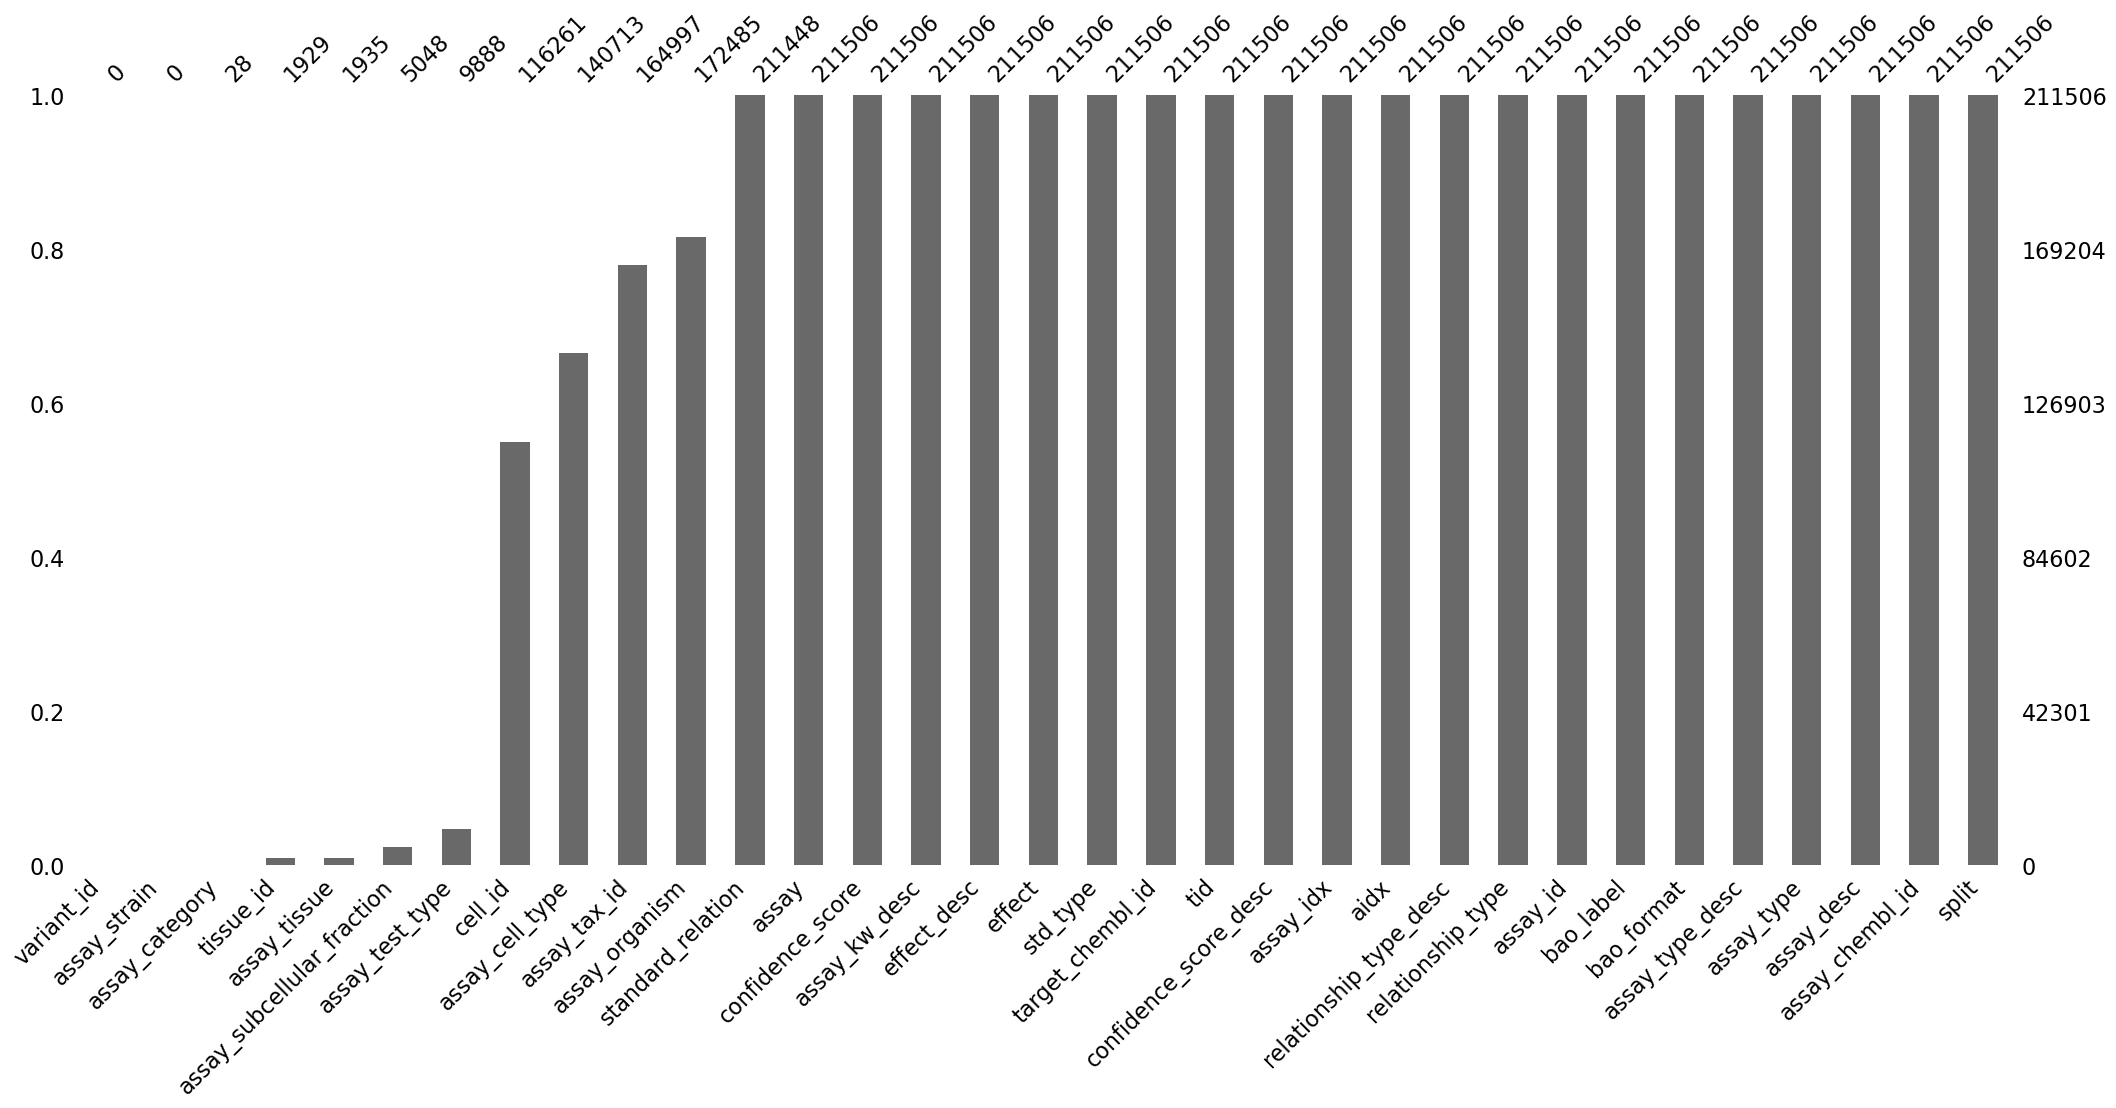

In [26]:
# ===== Visual summary of missing data by column =====
# count missing values per column
ms_counts = assay_info_df.isna().sum()
# reorder the columns by the ascending missing count
ordered_columns = ms_counts.sort_values(ascending=False).index
# Reorder the dataframe
assay_info_df = assay_info_df[ordered_columns]
# Plot the missing data
msno.bar(assay_info_df)

<Axes: >

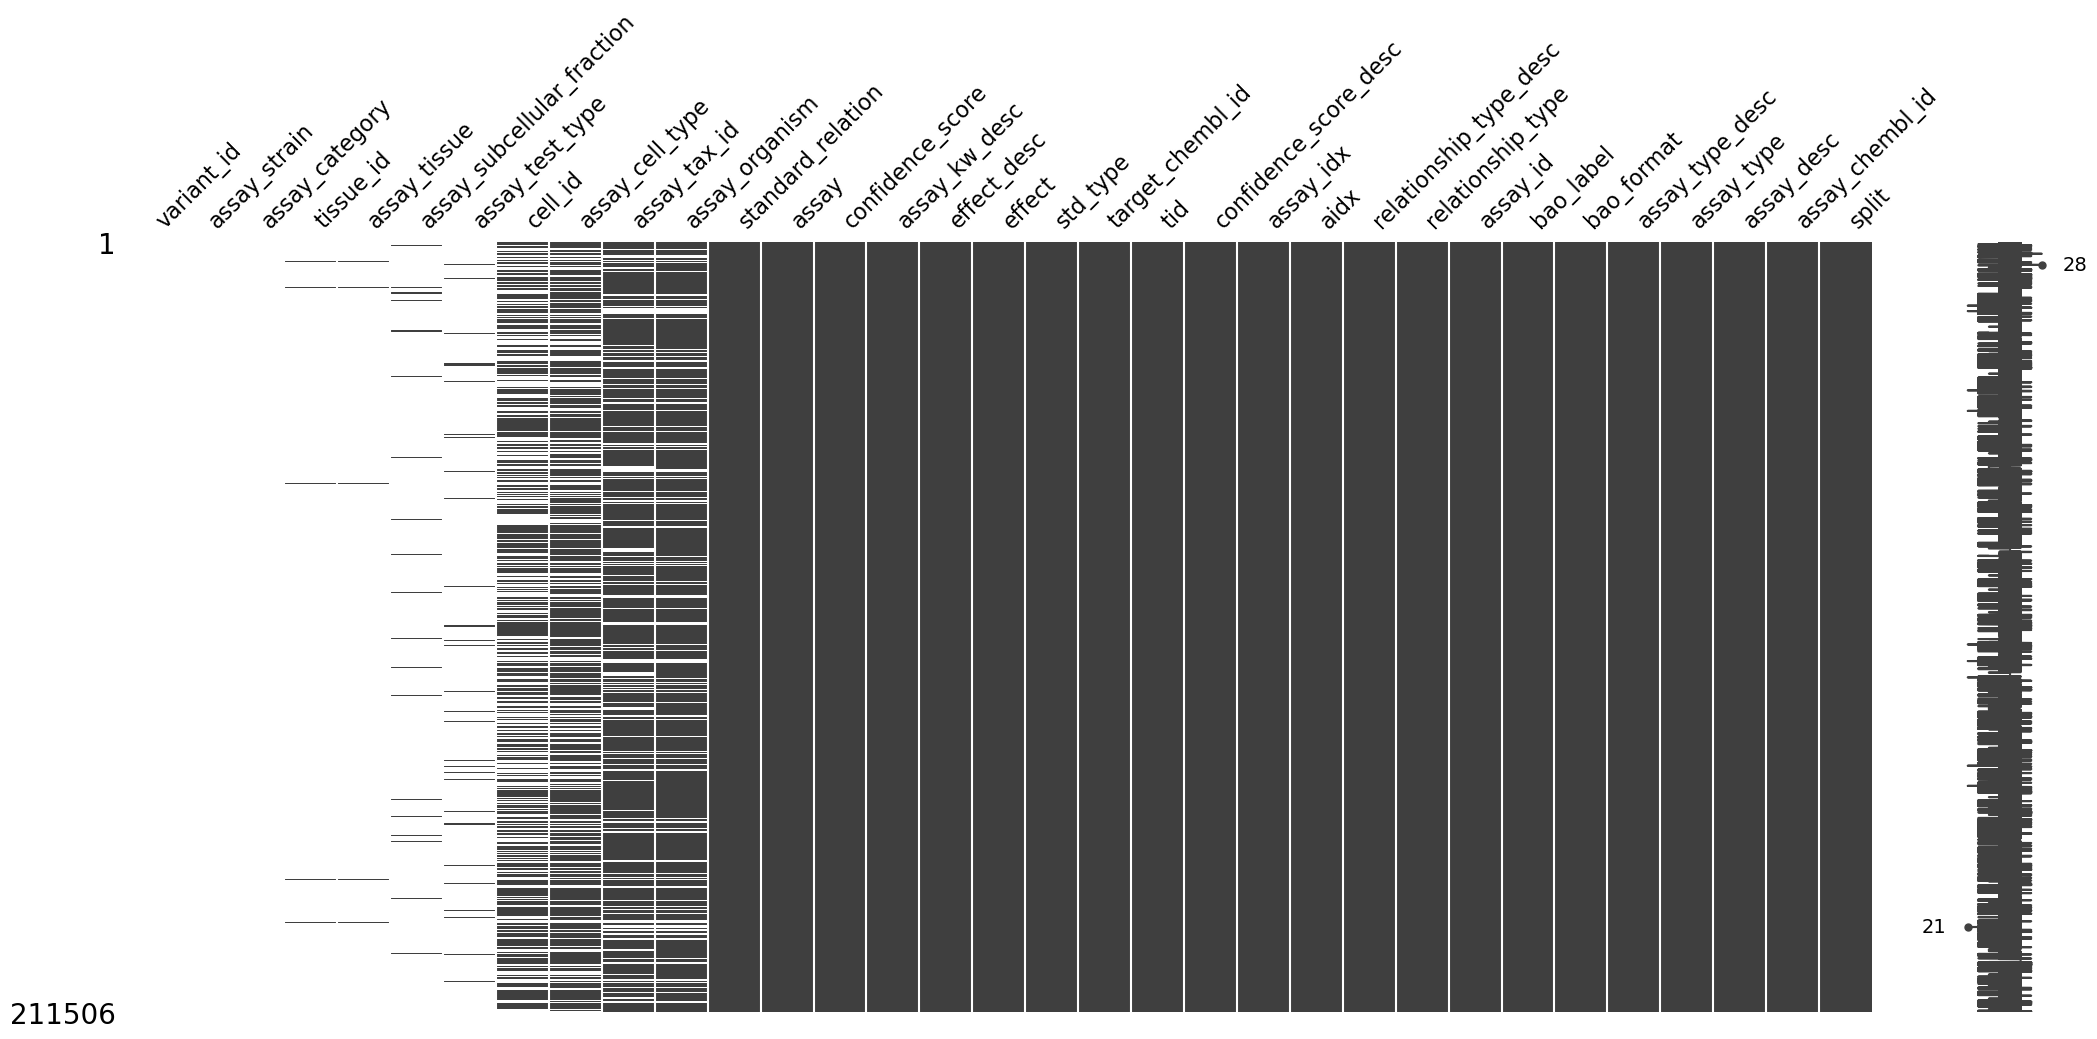

In [27]:
# Matrix-style visualization
msno.matrix(assay_info_df)